# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

# 1. Подготовка данных

In [2]:
data = pd.read_csv('Churn_Modelling.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
data.dropna(subset = ['Tenure'], inplace = True)
data['Tenure'] = data['Tenure'].astype('int')

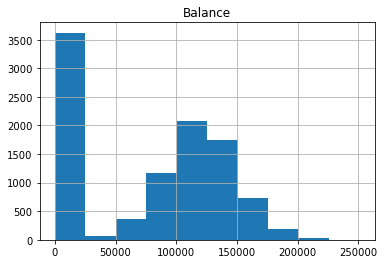

In [5]:
data.hist('Balance')
plt.show()

In [6]:
zero_balance = data.query('Balance == 0')
print('Клиентов с нулевым балансом:', len(zero_balance))
zero_balance.head()

Клиентов с нулевым балансом: 3617


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1
3,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.63,0
6,7,15592531,Bartlett,822,France,Male,50,7,0.0,2,1,1,10062.80,0
11,12,15737173,Andrews,497,Spain,Male,24,3,0.0,2,1,0,76390.01,0
12,13,15632264,Kay,476,France,Female,34,10,0.0,2,1,0,26260.98,0


In [7]:
#Удалим ненужные признаки
features_ignored = ['RowNumber', 'CustomerId', 'Surname']
data = data.drop(features_ignored, axis=1)

### Общий вывод:

Датасет состоит из 10 000 объектов и 14 признаков. Из них для обучения модели нам не понадобятся:

- RowNumber индекс строки в данных;
- CustomerId уникальный идентификатор;
- Surname фамилия клиента.

Целевой признак для нашей задачи – Exited, т.е. модель, которую мы попытаемся построить, будет предсказывать значение 1 если клиент уйдет или 0 если нет. В этом заключается наша задача классификации, т.к. целевой признак является категориальным.

Кроме того:

- В датасете представлены клиенты из трех стран EC: Франции ~50%, Германии ~25% и Испании ~25%.
- Признак Tenure (количество недвижимости у клиента) содержит 909 пропусков. Мы их удалили и привели признак к целочисленному типу.
- У 3 617 клиентов банка нулевой баланс на счете. Такая ситуация может быть вполне реалистичной – не у всех клиентов может быть положительный баланс. В реальной практике мы бы обязательно уточнили этот момент у коллег. Если бы мы убрали объекты, у которых баланс меньше 25 000 (это видно по гистограмме), то есть шанс, что модель будет плохо предсказывать в подобных случаях.

In [8]:
#Разделим данные на признаки и целевое значение
X = data.drop('Exited', axis=1)
y = data['Exited']

# 2. Исследование задачи

In [9]:
#Выделим категориальные и количественные признаки
cat_feat = ['Geography', 'Gender']
num_feat = X.columns.drop(cat_feat).to_list()

In [10]:
#Для категориальных признаков применим OHE
X = pd.get_dummies(X, columns=cat_feat, drop_first=True)
print(X.shape)
X.head(1)

(10000, 11)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.0,1,1,1,101348.88,0,0,0


In [11]:
#Разобьем данные на train и test, сохранив баланс классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

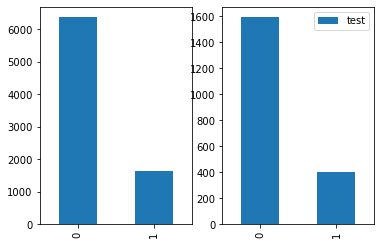

In [12]:
#Проверим дисбаланс целевого класса
f, (ax1, ax2) = plt.subplots(1, 2)
y_train.value_counts().plot(kind='bar', ax=ax1, label='train')
y_test.value_counts().plot(kind='bar', ax=ax2, label='test')
plt.legend()

Соотношение классов далеко от 1:1, т.е. они несбалансированы: ~80% отрицательных и ~20% положительных.

### Выбор модели

Рассмотрим три модели - дерево решений, логистическую регрессию и случайный лес.

Для каждого алгоритма подберем лучшие гиперпарамерты поиском по сетке по метрике f1.

In [13]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

##### Логистическая регрессия

In [14]:
param_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gcv = GridSearchCV(LogisticRegression(solver='liblinear'), param_lr, cv=skf, scoring="f1")
gcv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='f1')

In [15]:
gcv.best_estimator_, gcv.best_score_

(LogisticRegression(C=0.01, solver='liblinear'), 0.09824452273004296)

#### Дерево решений

In [16]:
tree_parameters = {'max_depth': [1, 3, 5, 7, 9, 11]}
tree = DecisionTreeClassifier(random_state=42)
gcv = GridSearchCV(tree, tree_parameters, n_jobs=-1, cv=skf, verbose=1, scoring="f1")
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11]}, scoring='f1',
             verbose=1)

In [17]:
gcv.best_estimator_, gcv.best_score_

(DecisionTreeClassifier(max_depth=7, random_state=42), 0.5539114805379219)

#### Случайный лес

In [18]:
rfc_parameters = {'n_estimators': [40, 60, 80, 100], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc = RandomForestClassifier(random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, rfc_parameters, n_jobs=-1, cv=skf, verbose=1, scoring="f1")
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   21.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'n_estimators': [40, 60, 80, 100]},
             scoring='f1', verbose=1)

In [19]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(max_depth=20, n_estimators=60, n_jobs=-1, oob_score=True,
                        random_state=42),
 0.5752980969946005)

In [20]:
model_rfc = RandomForestClassifier(random_state=42, n_estimators=60, 
                                   max_depth=20, n_jobs=-1, oob_score=True)

### Вывод

Как видим, модель случайного леса предсказывает чуть лучше, чем дерево решений и логистическая регрессия. Лучший результат 0.5727531140596294 достигается при количестве деревьев равном 100 и глубине равной 15.

# 3. Борьба с дисбалансом

Поробуем бороться с ним используя upsampling и downsampling

In [21]:
def upsampling(X, y, shuffled=True, seed=21):
    
    np.random.seed(seed)
    y_min_value = y.value_counts().sort_values().index[0]
    y_max_value = y.value_counts().sort_values().index[1]
    min_class_cnt = y.value_counts().min()
    max_class_cnt = y.value_counts().max()
    
    coef = max_class_cnt / min_class_cnt - 1
    idx = np.random.randint(0,
                            min_class_cnt,
                            size=np.round(min_class_cnt*coef).astype(int))
    
    X_new = X[y==y_min_value].values[idx]
    y_new = y[y==y_min_value].values[idx]
    
    X_up = pd.concat([X]+[pd.DataFrame(data=X_new, index=idx, columns=X.columns)])
    y_up = pd.concat([y]+[pd.Series(data=y_new, index=idx)])
    
    if shuffled:
        return shuffle(X_up, y_up, random_state=seed)
    else:
        return X_up, y_up

((12740, 11), (12740,))

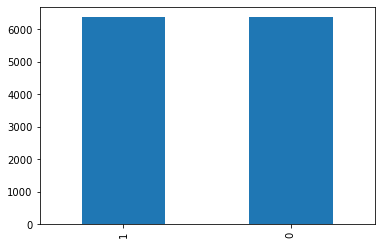

In [22]:
X_train_up, y_train_up = upsampling(X_train, y_train)

y_train_up.value_counts().plot(kind='bar')
X_train_up.shape, y_train_up.shape

Как видим upsampling помог выровнять дисбаланс классов

Дополнительно проверим не сломали ли мы распределение признаков на примере CreditScore

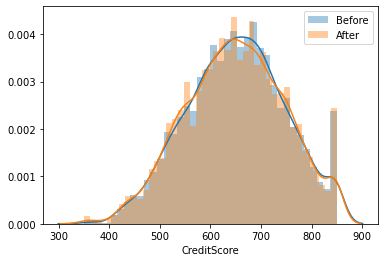

In [23]:
sns.distplot(X_train['CreditScore'], label='Before')
sns.distplot(X_train_up['CreditScore'], label="After")
plt.legend()

Как мы видим распределения практически идентичные


Реализуем downsampling, и выполним такие же проверки

In [24]:
def downsampling(X, y, shuffled=True, seed=21):
      
    np.random.seed(seed)
    y_min_value = y.value_counts().sort_values().index[0]
    y_max_value = y.value_counts().sort_values().index[1]
    min_class_cnt = y.value_counts().min()
    max_class_cnt = y.value_counts().max()
    
    idx = np.random.choice(max_class_cnt,
                           size=max_class_cnt - min_class_cnt,
                           replace=False)   
    print(idx.shape, max_class_cnt - min_class_cnt)
  
    X_down = X.drop(X[y==y_max_value].index[idx])
    y_down = y.drop(y[y==y_max_value].index[idx])
    
    if shuffled:
        return shuffle(X_down, y_down, random_state=seed)
    else:
        return X_down, y_down

(4740,) 4740


((3260, 11), (3260,))

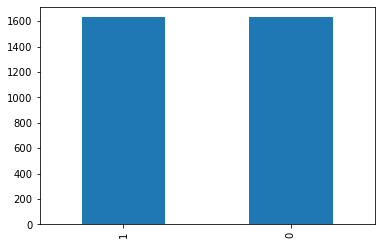

In [26]:
X_train_down, y_train_down = downsampling(X_train, y_train)

y_train_down.value_counts().plot(kind='bar')
X_train_down.shape, y_train_down.shape

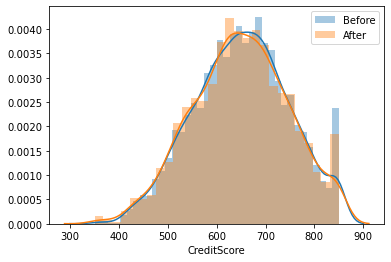

In [27]:
sns.distplot(X_train['CreditScore'], label='Before')
sns.distplot(X_train_down['CreditScore'], label="After")
plt.legend()

In [28]:
results = {'roc_auc_mean': [],
           'roc_auc_std': [],
           'f1_mean': [],
           'f1_std': []}

XX = [X_train, X_train_up, X_train_down]
yy = [y_train, y_train_up, y_train_down]
index = ['source', 'up', 'down']

metrics = ['roc_auc', 'f1']

for x, y, i in zip(XX, yy, index):
    for m in metrics:
        print('Calculate '+ m + ' metrics for '+ i, end='...')
        cv_score = cross_val_score(model_rfc, x, y, cv=skf, scoring=m)
        results[m + '_mean'].append(cv_score.mean())
        results[m + '_std'].append(cv_score.std())
        print('Done!')

pd.DataFrame(data=results, index=index)

Calculate roc_auc metrics for source...Done!
Calculate f1 metrics for source...Done!
Calculate roc_auc metrics for up...Done!
Calculate f1 metrics for up...Done!
Calculate roc_auc metrics for down...Done!
Calculate f1 metrics for down...Done!


,roc_auc_mean,roc_auc_std,f1_mean,f1_std
source,0.847205,0.012210,0.575298,0.034960
up,0.991199,0.002203,0.949740,0.005445
down,0.842489,0.013697,0.754168,0.015701


Мы видим существенный прирост качества на данных с upsampling

Это связано с переобучением модели, так как часть данных в результате перемешивания были и в обучающей и в валидационнй выборке на кросс валидации.

# 4. Тестирование модели

Доверимся тому что upsampling работает лучше.

Обучим лес и проверим его на тестовой выборке.

In [29]:
model_rfc.fit(X_train_up, y_train_up)
y_pred = model_rfc.predict(X_test)

In [30]:
f1_score(y_test, y_pred)

0.5905292479108635

<Figure size 432x288 with 0 Axes>

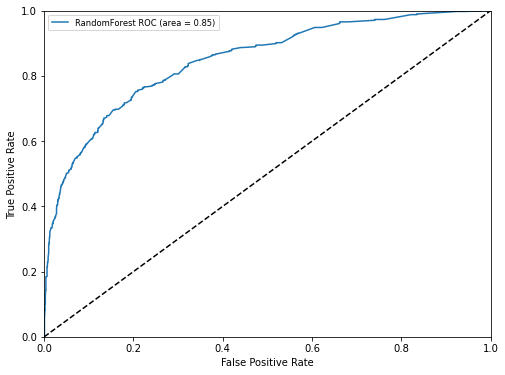

In [31]:
pl.clf()
plt.figure(figsize=(8,6))
#RandomForestClassifier
probas = model_rfc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandomForest',roc_auc))
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

AUC-ROC случайной модели равна 0.5 – наша метрика выше и понемногу стремиться к недостижимой едицине.